# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>**attention**</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

<h2>Learning Objectives:

*  **Understand the Transformer Architecture**: Gain a comprehensive understanding of the transformer model architecture.

*  **Develop the  Encoder and Decoder Modules**: Understand the individual components of the transformer's encoder and decoder modules, including positional encoding, multi-head attention, and feed-forward projections.

*  **Integrate the Complete Transformer Model**:  Combine the encoder and decoder modules to construct the full transformer model, and learn how to manage the flow of information between these components.

* **Understand the Value of Multi-Head Attention**: Learn how to use the multi-head attention mechanism and understand its significance in improving the model's ability to focus on different parts of the input sequence simultaneously.

* **Understand and Apply Pretraining Techniques**: Grasp the concept of pretraining by employing LSTMs as an initial embedding mechanism in a transformer's encoder. Learn the strategic process of incrementally training different components of a model — starting with a simple architecture (LSTM), then progressing to more complex structures (transformers). This objective underscores the role of pretraining and its gradual integration to enhance the overall efficacy of neural network models, culminating in superior performance metrics.

* **Enhance Training Efficiency Through Strategic Freezing**: Master the technique of selectively freezing and unfreezing model components at different stages of training. This approach aims to direct the model's learning capacity more effectively, concentrating on specific modules at a time. Understand how this method facilitates a more efficient training process, allowing various parts of the model to adapt incrementally. This objective highlights the value of phased learning, especially beneficial when integrating model components with varying learning dynamics.

*  **Tune Model Hyperparameters**: Experiment with different configurations of model hyperparameters, such as the number of layers, model dimensionality, and the number of attention heads, to help you understand the tradeoff between model complexity and dataset size.

<br>


[Kaggle Competition Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24)<br>

[Kaggle Dataset Link](https://www.kaggle.com/competitions/automatic-speech-recognition-s24/data)<br>

[Speech Transformer Paper](https://ieeexplore.ieee.org/document/8462506)<br>

[Attention Is All You Need Paper](https://arxiv.org/pdf/1706.03762.pdf)<br>

# Libraries

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [1]:
!nvidia-smi

Wed May  1 19:03:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
''' Installing some required libraries. '''
!pip install python-levenshtein torchsummaryX wandb kaggle pytorch-nlp --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


##  Imports

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as tat

from torchsummaryX import summary
from torch.autograd import Variable
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

import gc
import os
import math
import yaml
import random
import zipfile
import datetime

import glob
import wandb
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

''' Imports for decoding and distance calculation. '''
import Levenshtein

import warnings
warnings.filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


# Configurations

In [4]:
%%writefile config.yaml
train_dataset   : "train-clean-100"
cepstral_norm   : True
input_dim       : 27
batch_size      : 128
enc_dropout     : 0.2                   # [0.1, 0.4]
enc_num_layers  : 2                     # [1, 3]
enc_num_heads   : 4                     # [1, 4]
dec_dropout     : 0.2                   # [0.1, 0.4]
dec_num_layers  : 2                     # [1, 3]
dec_num_heads   : 4                     # [1, 4]
d_model         : 512                   # [256, 1024]
d_ff            : 2048                  # [512, 4096]
learning_rate   : 5E-4                  # [1E-3, 1E-4], this will depend on the specified optimizer
optimizer       : "AdamW"               # Adam, AdamW
momentum        : 0.0
nesterov        : True
scheduler       : "ReduceLR"     # CosineAnnealing, ReduceLR
factor          : 0.4
patience        : 5
epochs          : 50
###### Name --------------------------------------------------------------------
Name: "Dunhan"                                # write your name here for study group

Writing config.yaml


In [5]:
with open("config.yaml") as file:
    config = yaml.safe_load(file)

In [6]:
config

{'train_dataset': 'train-clean-100',
 'cepstral_norm': True,
 'input_dim': 27,
 'batch_size': 128,
 'enc_dropout': 0.2,
 'enc_num_layers': 2,
 'enc_num_heads': 4,
 'dec_dropout': 0.2,
 'dec_num_layers': 2,
 'dec_num_heads': 4,
 'd_model': 512,
 'd_ff': 2048,
 'learning_rate': '5E-4',
 'optimizer': 'AdamW',
 'momentum': 0.0,
 'nesterov': True,
 'scheduler': 'ReduceLR',
 'factor': 0.4,
 'patience': 5,
 'epochs': 50,
 'Name': 'Dunhan'}

# Kaggle Dataset Download

In [7]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:

    # Enter your kaggle username <USERNAME> and key <KEY> here.
    f.write('{"username":"dunhan777","key":"8fd87309c15da3fc8173ced30a2dfa76"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=b163efad0e869507a8453be5549e7f2b5b8bfb0232925c211fb8e708c0d8c37a
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.12
    Uninstalling kaggle-1.6.12:
      Successfully uninstalled kaggle-1.6.12


In [8]:
''' Downloading the dataset. '''
!kaggle competitions download -c automatic-speech-recognition-s24

''' Unzipping quickly and quietly. '''
!unzip -q automatic-speech-recognition-s24.zip -d ./data

100% 5.45G/5.46G [00:52<00:00, 155MB/s]
100% 5.46G/5.46G [00:52<00:00, 112MB/s]


# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar.

Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset? (do you require memory efficient loading techniques??)
- How do we load MFCCs? Do we need to normalize them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB -- is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [9]:
VOCAB = [
    "<pad>", "<sos>", "<eos>",
    "A",   "B",    "C",    "D",
    "E",   "F",    "G",    "H",
    "I",   "J",    "K",    "L",
    "M",   "N",    "O",    "P",
    "Q",   "R",    "S",    "T",
    "U",   "V",    "W",    "X",
    "Y",   "Z",    "'",    " ",
]

VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of Vocabulary    : {len(VOCAB)}")
print(f"VOCAB                   : {VOCAB}")
print(f"PAD_TOKEN               : {PAD_TOKEN}")
print(f"SOS_TOKEN               : {SOS_TOKEN}")
print(f"EOS_TOKEN               : {EOS_TOKEN}")

Length of Vocabulary    : 31
VOCAB                   : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN               : 0
SOS_TOKEN               : 1
EOS_TOKEN               : 2


## Dataset

In [10]:
''' This class is very similar to HW3P2 except for targets (now sequence of characters). '''

class SpeechDataset(torch.utils.data.Dataset):
    ''' memory inefficient : loading data in __init__ for simplicty

        You may decide to load data in __getitem__ if you wish.
        However, doing this memory inefficiently makes __init__ function takes
        the load of loading the data, and shifts it away from during the training process.
    '''

    def __init__(self, root_dir, partition, cepstral=True):
        self.mfcc_dir           = f"{root_dir}/{partition}*/mfcc/*"
        self.transcript_dir     = f"{root_dir}/{partition}*/transcripts/*"
        self.mfcc_files         = sorted(glob.glob(self.mfcc_dir))
        self.transcript_files   = sorted(glob.glob(self.transcript_dir))
        assert len(self.mfcc_files) == len(self.transcript_files)
        self.mfcc_files         = self.mfcc_files
        self.transcript_files   = self.transcript_files
        self.length             = len(self.transcript_files)
        self.vocab              = VOCAB
        print("Loaded Path: ", partition)
        self.mfccs, self.transcripts_shifted, self.transcripts_golden  = [], [], []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral:
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)
        for file in self.transcript_files:
            temp = np.load(file)[1:-1]
            # Why do we have two different types of targets? How do we want our decoder to know the start of sequence <SOS> and end of sequence <EOS>?
            self.transcripts_shifted.append(np.array([SOS_TOKEN] + [self.vocab.index(i) for i in temp]))
            self.transcripts_golden.append(np.array([self.vocab.index(i) for i in temp] + [EOS_TOKEN]))
        assert len(self.mfccs) == len(self.transcripts_shifted)
    def __len__(self): return self.length
    def __getitem__(self, ind):
        mfcc                = torch.FloatTensor(self.mfccs[ind])
        shifted_transcript  = torch.tensor(self.transcripts_shifted[ind])
        golden_transcript   = torch.tensor(self.transcripts_golden[ind])
        return mfcc, shifted_transcript, golden_transcript
    def collate_fn(self, batch):
        '''
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad both features and labels,
            look at PyTorch's documentation for pad_sequence.
        3.  This is a good place to perform transforms, if you so wish.
            Performing them on batches will speed the process up a bit.
        4.  Return batch of features, labels, lengths of features, and lengths of labels.
        '''
        # Batch of input mfcc coefficients.
        batch_mfcc              = [i[0] for i in batch]
        # Batch of output characters (shifted and golden).
        batch_transcript        = [i[1] for i in batch]
        batch_golden            = [i[2] for i in batch]
        lengths_mfcc            = [len(i) for i in batch_mfcc]
        lengths_transcript      = [len(i) for i in batch_transcript]
        # HINT: CHECK OUT -> pad_sequence (imported above)
        # Also be sure to check the input format (batch_first).
        batch_mfcc_pad          = pad_sequence(batch_mfcc, batch_first=True, padding_value=PAD_TOKEN)
        batch_transcript_pad    = pad_sequence(batch_transcript, batch_first=True, padding_value=PAD_TOKEN)
        batch_golden_pad        = pad_sequence(batch_golden, batch_first=True, padding_value=PAD_TOKEN)
        # You may apply some transformations, Time and Frequency masking, here in the collate function:
        # Food for Thought -> Why are we applying the transformation here and not in the __getitem__?
        #                  -> Would we apply transformation on the validation set as well?
        #                  -> Is the order of axes / dimensions as expected for the transform functions?
        # Return the following values: padded features, padded shifted labels, padded golden labels, actual length of features, actual length of the shifted labels
        return batch_mfcc_pad, batch_transcript_pad, batch_golden_pad, torch.tensor(lengths_mfcc), torch.tensor(lengths_transcript)

In [11]:
class SpeechTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, partition, cepstral=True):
        self.mfcc_dir       = f"{root_dir}/{partition}*/mfcc/*"
        self.mfcc_files     = sorted(glob.glob(self.mfcc_dir))
        self.length         = len(self.mfcc_files)
        self.mfccs = []
        for file in self.mfcc_files:
            mfcc = np.load(file)
            if cepstral: mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1E-8)
            self.mfccs.append(mfcc)
        print("Loaded Path: ", partition)
    def __len__(self): return self.length
    def __getitem__(self, ind):
        mfcc = self.mfccs[ind]
        return torch.FloatTensor(mfcc)
    def collate_fn(self, batch):
        '''
        TODO:
        1.  Extract the features and labels from 'batch'.
        2.  We will additionally need to pad the features,
            look at PyTorch's documentation for pad_sequence.
        3.  Return batch of features, lengths of features.
        '''
        batch_mfcc      = batch
        batch_mfcc_pad  = pad_sequence(batch_mfcc, batch_first=True)
        lengths_mfcc    = [len(i) for i in batch_mfcc]
        return batch_mfcc_pad, torch.tensor(lengths_mfcc)

In [12]:
# @NOTE: use the config file to specify PARTITION and CEPSTRAL
DATA_DIR        = '/content/data/11785-HW4P2' # Enter your data directory here.
PARTITION       = config["train_dataset"]     # Enter your training directory here.
CEPSTRAL        = config["cepstral_norm"]     # Enter your cepstral_norm parameter here.
train_dataset   = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)
val_dataset     = SpeechDataset(
    root_dir    = DATA_DIR,
    partition   = "dev-clean",
    cepstral    = CEPSTRAL
)
test_dataset    = SpeechTestDataset(
    root_dir    = DATA_DIR,
    partition   = "test-clean",
    cepstral    = CEPSTRAL,
)
gc.collect()

Loaded Path:  train-clean-100
Loaded Path:  dev-clean
Loaded Path:  test-clean


1254

## DataLoader

In [14]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config["batch_size"],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

val_loader      = torch.utils.data.DataLoader(
    dataset     = val_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = val_dataset.collate_fn,
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config["batch_size"],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn,
)

print("No. of Train MFCCs   : ", train_dataset.__len__())
print("Batch Size           : ", config["batch_size"])
print("Train Batches        : ", train_loader.__len__())
print("Val Batches          : ", val_loader.__len__())
print("Test Batches         : ", test_loader.__len__())

No. of Train MFCCs   :  28539
Batch Size           :  128
Train Batches        :  223
Val Batches          :  22
Test Batches         :  21


In [15]:
''' Sanity Check '''

print("Checking the Shapes of the Data --\n")

for batch in train_loader:
    x_pad, y_shifted_pad, y_golden_pad, x_len, y_len, = batch

    print(f"x_pad shape:\t\t{x_pad.shape}")
    print(f"x_len shape:\t\t{x_len.shape}\n")

    print(f"y_shifted_pad shape:\t{y_shifted_pad.shape}")
    print(f"y_golden_pad shape:\t{y_golden_pad.shape}")
    print(f"y_len shape:\t\t{y_len.shape}\n")

    # print(y_shifted_pad)

    break

Checking the Shapes of the Data --

x_pad shape:		torch.Size([128, 1688, 27])
x_len shape:		torch.Size([128])

y_shifted_pad shape:	torch.Size([128, 308])
y_golden_pad shape:	torch.Size([128, 308])
y_len shape:		torch.Size([128])



## DataLoader Verification

- Train Dataset (train-clean-50)
```
Loaded Path:  train-clean-50
Max MFCC Length          :  1982
Avg MFCC Length          :  1256.06069100848
Max Transcript Length    :  354
Max Transcript Length    :  182.2676431424767
```

- Train Dataset (train-clean-100)
```
Loaded Path:  train-clean-100
Max MFCC Length          :  2448
Avg MFCC Length          :  1264.6258453344547
Max Transcript Length    :  399
Max Transcript Length    :  186.65321139493324
```

- Validation Dataset
```
Loaded Path:  dev-clean
Max MFCC Length          :  3260
Avg MFCC Length          :  713.3570107288198
Max Transcript Length    :  517
Max Transcript Length    :  107.71698113207547
```

- Test Dataset
```
Loaded Path:  test-clean
Max MFCC Length          :  27
Avg MFCC Length          :  27.0
```

- Population Stats
```
Max Length:  3260
```

If your values is not matching, read hints and think what could have gone wrong. Then approach TAs.



# Introduction

Transformers are highly effective for speech recognition tasks because they utilize self-attention mechanisms, enabling them to analyze entire sequences of audio data in one shot. This allows for a nuanced understanding of long-range dependencies and the complex temporal dynamics inherent in speech. Compared to traditional models, transformers offer improved accuracy and efficiency, adeptly handling variations in speech patterns, accents, and intonations; thus, making them exceptionally suitable for advanced speech recognition applications.

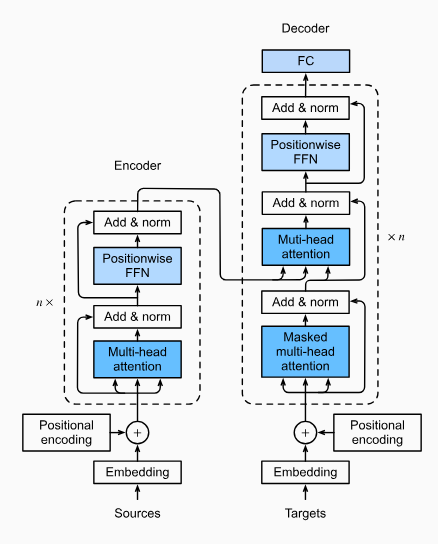

Given the complicated nature of these models, training in this homework will be a little different from other homeworks.<br>
We will employ the following to effectively train the transformer with fewer resources (data and compute power).
<br>
* **Data Complexity and Model Capacity**:  Starting with a CNN-LSTM for input sequences captures temporal dynamics and dependencies early on, simplifying initial learning. This is effective for data with strong temporal or sequential patterns, which LSTMs excel at handling. We will use an already trained model (trained in HW3P2).


* **Gradual (Incremental) Learning**: Starting with a simpler model (like an LSTM) allows the neural network to first learn the basic structures and patterns in the data. When we later introduce more complex mechanisms (like a transformer encoder), the model already has a foundational understanding of the data. This foundation can lead to a smoother and more effective learning process when the complexity of the model increases. In other words, we are using a simple, pretrained LSTM encoder as the basis for our transformer decoder and incrementally adding complexity!

* **Learning Efficiency**: By freezing certain parts of the model during different stages of training, we focus the learning capacity of the network on specific modules, making the training process more efficient. This stepwise unfreezing and training allows different components of the model to adapt gradually, which can be very useful when integrating parts of the model that learn at different rates.

* **Adaptation to Data Characteristics**: This strategy implicitly takes advantage of the data's characteristics by adjusting the model's architecture and training procedure to better suit the data's structure. For instance, if the data contains intricate sequential patterns, starting with an LSTM can harness these patterns effectively. Then, by introducing a transformer encoder, the model can further learn to capture complex, long-range dependencies within the data, something transformers are exceptionally good at.


## Utilities

To make make building the transformer easy, we will define various utility functions and classes which corresponds to the various modules of the transformer. All Components are provided for you but your task will be too understand the modules as you will need  them in answering Canvas quizzes as well as implementing other parts of this notebook. Please refer to the write-up for more information.

In [16]:
def create_mask_1(padded_input, input_lengths=None, pad_idx=None):
    """ Create a mask to identify non-padding positions.

    Args:
        padded_input: The input tensor with padding, shape (N, T, ...) or (N, T).
        input_lengths: Optional, the actual lengths of each sequence before padding, shape (N,).
        pad_idx: Optional, the index used for padding tokens.

    Returns:
        A mask tensor with shape (N, T, 1), where non-padding positions are marked with 1 and padding positions are marked with 0.
    """

    assert input_lengths is not None or pad_idx is not None

    # Create a mask based on input_lengths
    if input_lengths is not None:
        N = padded_input.size(0)        # padded_input : (N x T x ...)
        non_pad_mask = padded_input.new_ones(padded_input.size()[:-1])  # (N x T)

        # Set the mask to 0 for padding positions
        for i in range(N):
          non_pad_mask[i, input_lengths[i]:] = 0

    if pad_idx is not None:             # padded_input : N x T

        assert padded_input.dim() == 2

        # Create a mask where non-padding positions are marked with 1 and padding positions are marked with 0
        non_pad_mask = padded_input.ne(pad_idx).float()

    return non_pad_mask.unsqueeze(-1)   # unsqueeze(-1) for broadcasting

In [17]:
def create_mask_2(seq, pad_idx=None):
    """ Create a mask to prevent positions from attending to subsequent positions.

    Args:
        seq: The input sequence tensor, shape (batch_size, sequence_length).

    Returns:
        A mask tensor with shape (batch_size, sequence_length, sequence_length),
            where positions are allowed to attend to previous positions but not to subsequent positions.
    """

    sz_b, len_s = seq.size()

    # Create an upper triangular matrix with zeros on the diagonal and below (indicating allowed positions)
    #   and ones above the diagonal (indicating disallowed positions)
    subsequent_mask = torch.triu(
        torch.ones((len_s, len_s), device=seq.device, dtype=torch.uint8), diagonal=1)

    # Expand the mask to match the batch size, resulting in a mask for each sequence in the batch.
    mask = subsequent_mask.unsqueeze(0).expand(sz_b, -1, -1)  # b x ls x ls


    ''' Create a mask to ignore padding positions in the key sequence during attention calculation. '''

    # Expanding to fit the shape of key query attention matrix.
    if pad_idx != None:
      len_q = seq.size(1)

      # Create a mask where padding positions in the key sequence are marked with 1.
      padding_mask  = seq.eq(pad_idx)

      # Expand the mask to match the dimensions of the key-query attention matrix.
      padding_mask  = padding_mask.unsqueeze(1).expand(-1, len_q, -1)  # b x lq x lk
      mask          = (padding_mask + mask).gt(0)

    else:
      mask = mask.gt(0)

    return mask

In [18]:
def create_mask_3(padded_input, input_lengths, expand_length):
    """ Create an attention mask to ignore padding positions in the input sequence during attention calculation.

    Args:
        padded_input: The input tensor with padding, shape (N, Ti, ...).
        input_lengths: The actual lengths of each sequence before padding, shape (N,).
        expand_length: The length to which the attention mask should be expanded,
            usually equal to the length of the sequence that the attention scores will be applied to.

    Returns:
        An attention mask tensor with shape (N, expand_length, Ti),
            where padding positions in the input sequence are marked with 1 and other positions are marked with 0.
    """

    # Create a mask to identify non-padding positions, shape (N, Ti, 1)
    # (N x Ti x 1)
    non_pad_mask    = create_mask_1(padded_input, input_lengths=input_lengths)

    # Invert the mask to identify padding positions, shape (N, Ti)
    # N x Ti, lt(1) like-not operation
    pad_mask        = non_pad_mask.squeeze(-1).lt(1)


    # Expand the mask to match the dimensions of the attention matrix, shape (N, expand_length, Ti)
    attn_mask       = pad_mask.unsqueeze(1).expand(-1, expand_length, -1)

    return attn_mask

In [19]:
class ScaledDotProductAttention(torch.nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature    = temperature                       # Scaling factor for the dot product
        self.dropout        = torch.nn.Dropout(attn_dropout)    # Dropout layer for attention weights
        self.softmax        = torch.nn.Softmax(dim=2)           # Softmax layer along the attention dimension

    def forward(self, q, k, v, mask=None):

        # Calculate the dot product between queries and keys.
        attn = torch.bmm(q, k.transpose(1, 2))

        # Scale the dot product by the temperature.
        attn = attn / self.temperature

        if mask is not None:
            # Apply the mask by setting masked positions to a large negative value.
            # This ensures they have a softmax score close to zero.
            mask_value = -1e+30 if attn.dtype == torch.float32 else -1e+4
            attn = attn.masked_fill(mask, mask_value)

        # Apply softmax to obtain attention weights.
        attn    = self.softmax(attn)

        # Apply dropout to the attention weights.
        attn    = self.dropout(attn)

        # Compute the weighted sum of values based on the attention weights.
        output  = torch.bmm(attn, v)

        return output, attn # Return the attention output and the attention weights.

In [20]:
def save_attention_plot(attention_weights, epoch=0):
    ''' function for saving attention weights plot to a file

        @NOTE: default starter code set to save cross attention
    '''

    plt.clf()  # Clear the current figure
    sns.heatmap(attention_weights, cmap="GnBu")  # Create heatmap

    # Save the plot to a file. Specify the directory if needed.
    plt.savefig(f"cross_attention-epoch{epoch}.png")

In [21]:
class MultiHeadAttention(torch.nn.Module):
    ''' Multi-Head Attention Module '''

    def __init__(self, n_head, d_model, dropout=0.1):
        super().__init__()

        self.n_head = n_head # Number of attention heads
        self.d_k    = d_model // n_head
        self.d_v    = d_model // n_head


        # Linear layers for projecting the input query, key, and value to multiple heads
        self.w_qs   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_ks   = torch.nn.Linear(d_model, n_head * self.d_k)
        self.w_vs   = torch.nn.Linear(d_model, n_head * self.d_v)

        torch.nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_k)))
        torch.nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + self.d_v)))

        # Initialize the weights of the linear layers
        self.attention = ScaledDotProductAttention(
            temperature=np.power(self.d_k, 0.5), attn_dropout=dropout)

        # Final linear layer to project the concatenated outputs of the attention heads back to the model dimension
        self.fc = torch.nn.Linear(n_head * self.d_v, d_model)

        torch.nn.init.xavier_normal_(self.fc.weight)

        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):

        # following key, value, query standard computation
        d_k, d_v, n_head    = self.d_k, self.d_v, self.n_head
        sz_b, len_q, _      = q.size()
        sz_b, len_k, _      = k.size()
        sz_b, len_v, _      = v.size()

        # Project the input query, key, and value to multiple heads
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Rearrange the dimensions to group the heads together for parallel processing
        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv

        # Repeat the mask for each attention head if a mask is provided
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1)

        # Apply scaled dot-product attention to the projected query, key, and value
        output, attn    = self.attention(q, k, v, mask=mask)

        # Rearrange the output back to the original order and concatenate the heads
        output          = output.view(n_head, sz_b, len_q, d_v)
        output          = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output          = self.dropout(self.fc(output))

        return output, attn

## Transformer Modules

### Positional Encoding

In [22]:
class PositionalEncoding(torch.nn.Module):
    ''' Position Encoding from Attention Is All You Need Paper '''

    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Initialize a tensor to hold the positional encodings
        pe          = torch.zeros(max_len, d_model)

        # Create a tensor representing the positions (0 to max_len-1)
        position    = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

        # Calculate the division term for the sine and cosine functions
        # This term creates a series of values that decrease geometrically, used to generate varying frequencies for positional encodings
        div_term    = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Compute the positional encodings using sine and cosine functions
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Reshape the positional encodings tensor and make it a buffer
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):

      return x + self.pe[:, :x.size(1)]

### Feed Forward Networks

In [23]:
class FeedForward(torch.nn.Module):
    ''' Projection Layer (Fully Connected Layers) '''

    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super().__init__()

        self.linear_1   = torch.nn.Linear(d_model, d_ff)
        self.dropout    = torch.nn.Dropout(dropout)
        self.linear_2   = torch.nn.Linear(d_ff, d_model)

    def forward(self, x):

        # Apply the first linear layer, GeLU activation, and then dropout
        x = self.dropout(torch.nn.functional.gelu(self.linear_1(x)))

         # Apply the second linear layer to project the dimension back to d_model
        x = self.linear_2(x)

        return x

# PART #1 (Preliminary Submission)

In this part we will use a simple CNN-LSTM as an encoder with a Transformer Decoder (with Self-Attention and Cross-Attention).

## CNN-LSTM Encoder

In [24]:
class Permute(nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

In [25]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()
        self.blstm = torch.nn.LSTM(input_size=2*input_size, hidden_size=hidden_size, bidirectional=True, batch_first=True)
    def forward(self, x_pack):
        x_pad, x_lens = pad_packed_sequence(x_pack, batch_first=True)
        x_pad, x_lens = self.trunc_reshape(x_pad, x_lens)
        output_packed, _ = self.blstm(pack_padded_sequence(x_pad, x_lens, batch_first=True, enforce_sorted=False))
        return output_packed
    def trunc_reshape(self, x, x_lens):
        if x.shape[1]%2 == 1: x = x[:,:-1,:]
        return x.reshape((x.shape[0], int(x.shape[1]//2), x.shape[2]*2)), (x_lens/2).type(torch.int)

In [26]:
from torch.autograd import Variable
class LockedDropout(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.dropout = dropout
    def forward(self, x):
        if not self.training or not self.dropout: return x
        x_unpack, x_len = pad_packed_sequence(x, batch_first=True)
        mask = Variable(x.data.new(x_unpack.size(0), 1, x_unpack.size(2)).bernoulli_(1 - self.dropout), requires_grad=False) / (1 - self.dropout)
        out = mask.expand_as(x_unpack) * x_unpack
        return pack_padded_sequence(out, lengths=x_len, batch_first=True, enforce_sorted=False)

In [27]:
class CNN_LSTM_Encoder(torch.nn.Module):
    ''' The Encoder takes utterances as inputs and returns latent feature representations '''
    def __init__(self, input_size, encoder_hidden_size, enc_dropout=0.25):
        super(CNN_LSTM_Encoder, self).__init__()
        self.embedding = torch.nn.Sequential(
            torch.nn.Conv1d(input_size, 2 * input_size, kernel_size = 5, stride = 1, padding = 2),
            torch.nn.BatchNorm1d(2 * input_size),
            torch.nn.ReLU(inplace = True),
            torch.nn.Conv1d(2 * input_size, 4 * input_size, kernel_size = 5, stride = 1, padding = 2),
            torch.nn.BatchNorm1d(4 * input_size),
            torch.nn.ReLU(inplace = True)
        )
        self.bilstm = torch.nn.LSTM(input_size = 4 * input_size,
                                    hidden_size = encoder_hidden_size,
                                    bidirectional = True,
                                    batch_first = True,
                                    dropout = enc_dropout)
        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(2 * encoder_hidden_size, encoder_hidden_size),
            LockedDropout(dropout = 2 * enc_dropout),
            pBLSTM(2 * encoder_hidden_size, 2 * encoder_hidden_size),
            LockedDropout(dropout = enc_dropout),
        )
        self.permute = Permute()
    def forward(self, x, x_lens):
        x_em = self.embedding(self.permute(x))
        x_pack = pack_padded_sequence(self.permute(x_em), x_lens, batch_first = True, enforce_sorted = False)
        x_pack, _ = self.bilstm(x_pack)
        x_pack = self.pBLSTMs(x_pack)
        encoder_outputs, encoder_lens = pad_packed_sequence(x_pack, batch_first = True)
        return encoder_outputs, encoder_lens

## Transformer Decoder

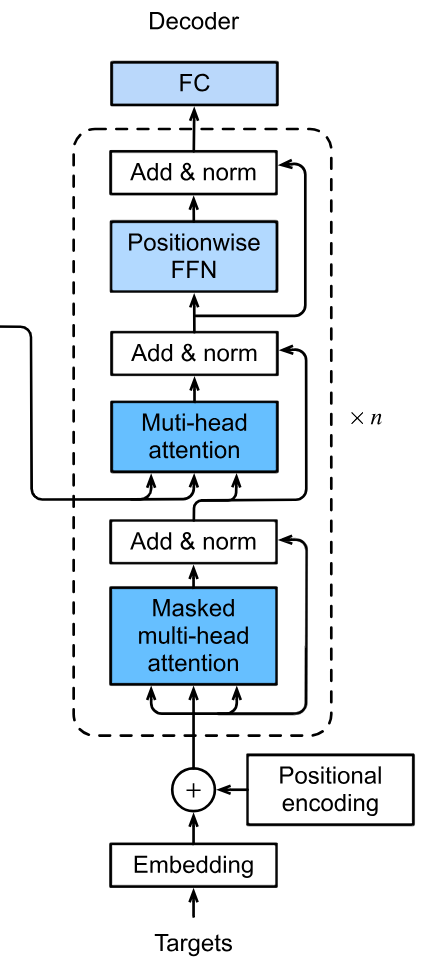

Tips to complete the Decoder below.

* Can you seperate the decoder layers from the whole decoder?
* How many multi-head attention do we have in the figure above.
* How many layer normalizations?
* How do we make the residual connections?

For Forward Method:
* What are the inputs to various multi-head attention modules?
* How do we make the residual connection (do we need dropout)?


In [28]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        # @TODO: fill in the blanks appropriately (given the modules above)
        self.mha1       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.mha2       = MultiHeadAttention(num_heads, d_model, dropout=dropout)
        self.ffn        = FeedForward(d_model, d_ff)

        self.layernorm1 = torch.nn.LayerNorm(d_model)
        self.layernorm2 = torch.nn.LayerNorm(d_model)
        self.layernorm3 = torch.nn.LayerNorm(d_model)

        self.dropout1   = torch.nn.Dropout(dropout)
        self.dropout2   = torch.nn.Dropout(dropout)
        self.dropout3   = torch.nn.Dropout(dropout)

    def forward(self, padded_targets, enc_output, enc_input_lengths, dec_enc_attn_mask, pad_mask, slf_attn_mask):
        # Masked Multi-head Attention
        att_out, att = self.mha1(padded_targets, padded_targets, padded_targets, slf_attn_mask)
        att_out = self.dropout1(att_out)
        # Skip (Residual) Connections + Layer Normalization
        out = self.layernorm1(padded_targets + att_out)
        # Masked Multi-Head Attention on Encoder Outputs and Targets
        crossatt_out, cross_att = self.mha2(out, enc_output, enc_output, dec_enc_attn_mask)
        crossatt_out = self.dropout2(crossatt_out)
        # Skip (Residual) Connections + Layer Normalization
        out = self.layernorm2(out + crossatt_out)
        # Feed Forward Network
        ffn_out = self.dropout3(self.ffn(out))
        # Skip (Residual) Connections + Layer Normalization
        output = self.layernorm3(out + ffn_out)

        return output, att, cross_att

In [29]:
class Decoder(torch.nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout,
            target_vocab_size, max_seq_length, eos_token, sos_token, pad_token):
        super().__init__()

        self.EOS_TOKEN      = eos_token
        self.SOS_TOKEN      = sos_token
        self.PAD_TOKEN      = pad_token

        self.max_seq_length = max_seq_length
        self.num_layers     = num_layers

        # use torch.nn.ModuleList() with list comprehension looping through num_layers
        # @NOTE: think about what stays constant per each DecoderLayer (how to call DecoderLayer)
        # @HINT: We've implemented this for you.
        self.dec_layers = torch.nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)]
        )

        self.target_embedding       = nn.Embedding(target_vocab_size, d_model)
        self.positional_encoding    = PositionalEncoding(d_model)
        self.final_linear           = nn.Linear(d_model, target_vocab_size)
        self.dropout                = nn.Dropout(dropout)


    def forward(self, padded_targets, enc_output, enc_input_lengths):

        # create a padding mask for the padded_targets with <PAD_TOKEN>
        ''' TODO '''
        mask1 = create_mask_1(padded_targets, pad_idx=self.PAD_TOKEN)

        # creating an attention mask for the future subsequences (look-ahead mask)
        ''' TODO '''
        mask2 = create_mask_2(padded_targets, pad_idx=self.PAD_TOKEN)

        # creating attention mask to ignore padding positions in the input sequence during attention calculation
        ''' TODO '''
        mask3 = create_mask_3(enc_output, enc_input_lengths, padded_targets.size(1))

        # computing embeddings for the target sequence
        ''' TODO '''
        embedding = self.target_embedding(padded_targets)

        # computing Positional Encodings with the embedded targets and apply dropout
        ''' TODO '''
        position = self.positional_encoding(embedding)

        embedding = self.dropout(position)

        # passing through decoder layers
        # @NOTE: store your mha1 and mha2 attention weights inside a dictionary
        # @NOTE: you will want to retrieve these later so store them with a useful name
        ''' TODO '''
        attns = {}
        for layer in self.dec_layers:
            embedding, self_attn, cross_attn = layer(embedding, enc_output, enc_input_lengths, mask3, mask1, mask2)

        # linear layer (Final Projection) for next character prediction
        ''' TODO '''
        attns["self_attn"] = self_attn
        attns["cross_attn"] = cross_attn

        # return the network output and the dictionary of attention weights
        return self.final_linear(embedding), attns


    def recognize_greedy_search(self, enc_outputs, enc_input_lengths):
        ''' passes the encoder outputs and its corresponding lengths through autoregressive network

            @NOTE: You do not need to make changes to this method.
        '''

        batch_size = enc_outputs.size(0)

        # start with the <SOS> token for each sequence in the batch
        target_seq = torch.full((batch_size, 1), self.SOS_TOKEN, dtype=torch.long).to(enc_outputs.device)

        finished = torch.zeros(batch_size, dtype=torch.bool).to(enc_outputs.device)

        for _ in range(self.max_seq_length):

            # preparing attention masks
            # filled with ones becaues we want to attend to all the elements in the sequence
            pad_mask = torch.ones_like(target_seq).float().unsqueeze(-1)  # (batch_size x i x 1)
            slf_attn_mask_subseq = create_mask_2(target_seq)

            x = self.positional_encoding(self.target_embedding(target_seq))

            for i in range(self.num_layers):
                x, block1, block2 = self.dec_layers[i](
                    x, enc_outputs, enc_input_lengths, None, pad_mask, slf_attn_mask_subseq)

            seq_out = self.final_linear(x[:, -1])
            logits = torch.nn.functional.log_softmax(seq_out, dim=1)

            # selecting the token with the highest probability
            # @NOTE: this is the autoregressive nature of the network!
            next_token = logits.argmax(dim=-1).unsqueeze(1)

            # appending the token to the sequence
            target_seq = torch.cat([target_seq, next_token], dim=-1)

            # checking if <EOS> token is generated
            eos_mask = next_token.squeeze(-1) == self.EOS_TOKEN
            # or opration, if both or one of them is true store the value of the finished sequence in finished variable
            finished |= eos_mask

            # end if all sequences have generated the EOS token
            if finished.all(): break

        # remove the initial <SOS> token and pad sequences to the same length
        target_seq = target_seq[:, 1:]
        max_length = target_seq.size(1)
        target_seq = torch.nn.functional.pad(target_seq,
            (0, self.max_seq_length - max_length), value=self.PAD_TOKEN)

        return target_seq

## CNN-LSTM Encoder + Speech Transformer Decoder

In this section, let's build the first (simplest) Transformer network by combining the CNN-LSTM encoder and our Transformer Decoder.

In [30]:
class SpeechTransformer(torch.nn.Module):

    def __init__(self, input_dim, dec_num_layers, dec_num_heads,
                    d_model, d_ff, target_vocab_size, eos_token, sos_token,
                    pad_token, enc_dropout, dec_dropout, max_seq_length=512):

        super(SpeechTransformer, self).__init__()

        self.encoder    = CNN_LSTM_Encoder(input_dim, 256, enc_dropout)

        self.proj       = torch.nn.Linear(1024, d_model)

        self.decoder    = Decoder(dec_num_layers, d_model, dec_num_heads, d_ff,
                dec_dropout, target_vocab_size, max_seq_length, eos_token, sos_token, pad_token)

        for p in self.parameters():
            if p.dim() > 1: torch.nn.init.xavier_uniform_(p)

    def forward(self, padded_input, input_lengths, padded_target, target_lengths):

        # passing through Encoder
        encoder_output, encoder_len = self.encoder(padded_input, input_lengths)

        # adding projection layer to change dimension of encoder_outputs to match d_model
        encoder_output = self.proj(encoder_output)

        # @NOTE: adding layernorm to adjust dynamic ranges of the encoder_outputs
        # @NOTE: uncomment this if you choose to use layernorm described in __init__ above
        # encoder_output = self.layernorm(encoder_output)

        # passing Encoder output and Attention masks through Decoder
        output, attention_weights = self.decoder(padded_target, encoder_output, encoder_len)

        return output, attention_weights

    def recognize(self, inp, inp_len):
        """ sequence-to-sequence greedy search -- decoding one utterence at a time """

        encoder_outputs, encoder_len  = self.encoder(inp, inp_len)
        encoder_outputs                = self.proj(encoder_outputs)
        out                            = self.decoder.recognize_greedy_search(encoder_outputs, encoder_len)

        return out

## Model Setup


In [31]:
torch.cuda.empty_cache()
gc.collect()

0

In [32]:
''' Please refer to the config file and top sections to fill in the following '''

model = SpeechTransformer(
input_dim                   = config['input_dim'],
dec_num_layers              = config['dec_num_layers'],
dec_num_heads               = config['dec_num_heads'],

d_model                     = config['d_model'],
d_ff                        = config['d_ff'],

target_vocab_size           = len(VOCAB),
eos_token                   = 2,
sos_token                   = 1,
pad_token                   = 0,

enc_dropout                 = config['enc_dropout'],
dec_dropout                 = config['dec_dropout'],

# decrease to a small number if you are just trying to implement the network
max_seq_length              = 550 , # Max sequence length for transcripts. Check data verification.
).to(device)

def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6

para = num_parameters(model)
print("#"*10)
print(f"Model Parameters:\n {para}")
print("#"*10)

Model Summary:
SpeechTransformer(
  (encoder): CNN_LSTM_Encoder(
    (embedding): Sequential(
      (0): Conv1d(27, 54, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv1d(54, 108, kernel_size=(5,), stride=(1,), padding=(2,))
      (4): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (bilstm): LSTM(108, 256, batch_first=True, dropout=0.2, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): pBLSTM(
        (blstm): LSTM(1024, 256, batch_first=True, bidirectional=True)
      )
      (1): LockedDropout()
      (2): pBLSTM(
        (blstm): LSTM(1024, 512, batch_first=True, bidirectional=True)
      )
      (3): LockedDropout()
    )
    (permute): Permute()
  )
  (proj): Linear(in_features=1024, out_features=512, bias=True)
  (decoder): Decoder(
    (dec_layers): ModuleList(
      

### Loading the CNN-LSTM Checkpoint

---
For ease of training we use a pretrained LSTM -- load the .pth file.

Download the weights from here - https://drive.google.com/file/d/1wRcHwCvxksxiPv6WQykOkY9i4bip-ooa/view?usp=sharing

## Loss, Optimizer, and Scheduler Definitions

In [33]:
loss_func   = nn.CrossEntropyLoss(ignore_index = PAD_TOKEN)
scaler      = torch.cuda.amp.GradScaler()

In [34]:
''' defining optimizer '''

if config["optimizer"] == "SGD":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.SGD(model.parameters(),
                              lr=config["learning_rate"],
                              momentum=config["momentum"],
                              weight_decay=1E-4,
                              nesterov=config["nesterov"])

elif config["optimizer"] == "Adam":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.Adam(model.parameters(),
                               lr=float(config["learning_rate"]),
                               weight_decay=1e-4)

elif config["optimizer"] == "AdamW":
  # feel free to change any of the initializations you like to fit your needs
  optimizer = torch.optim.AdamW(model.parameters(),
                                lr=float(config["learning_rate"]),
                                weight_decay=0.01)

''' defining scheduler '''

if config["scheduler"] == "ReduceLR":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                factor=config["factor"], patience=config["patience"], min_lr=1E-8, verbose=True)

elif config["scheduler"] == "CosineAnnealing":
  #Feel Free to change any of the initializations you like to fit your needs
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                T_max = config["epochs"], eta_min=1E-8)

In [35]:
def save_model(model, optimizer, scheduler, metric, epoch, path):
    torch.save(
        {"model_state_dict"         : model.state_dict(),
         "optimizer_state_dict"     : optimizer.state_dict(),
         "scheduler_state_dict"     : scheduler.state_dict() if scheduler is not None else {},
         metric[0]                  : metric[1],
         "epoch"                    : epoch},
         path
    )

def load_model(path, model, metric= "valid_acc", optimizer= None, scheduler= None):

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])

    if optimizer != None:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler != None:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    epoch   = checkpoint["epoch"]
    metric  = checkpoint[metric]

    return [model, optimizer, scheduler, epoch, metric]

## Training and Validation Modules

### Levenshtein Distance

In [36]:
''' utility function which takes a sequence of indices and converts them to a list of characters '''
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices:   # looping through all indices

        if int(i) == SOS_TOKEN:     # If SOS is encountered, don't add it to the final list
            continue
        elif int(i) == EOS_TOKEN:   # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])

    return tokens

In [37]:
''' utility function for Levenshtein Distantce quantification '''
def calc_edit_distance(predictions, y, y_len, vocab=VOCAB, print_example=False):

    dist = 0.0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx, 0 : y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # strings - when you are using characters from the SpeechDataset
        y_string    = "".join(y_sliced)
        pred_string = "".join(pred_sliced)

        dist        += Levenshtein.distance(pred_string, y_string)

    if print_example:
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist /= batch_size

    return dist

### Training and Validation Functions

In [38]:
def train_model(model, train_loader, optimizer):

    model.train()
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc="Train")

    total_loss          = 0
    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(train_loader):

        optimizer.zero_grad()

        inputs          = inputs.to(device)
        targets_shifted = targets_shifted.to(device)
        targets_golden  = targets_golden.to(device)

        with torch.cuda.amp.autocast():
            # passing the minibatch through the model
            raw_predictions, attention_weights = model(inputs, inputs_lengths, targets_shifted, targets_lengths)

            padding_mask = torch.logical_not(torch.eq(targets_shifted, PAD_TOKEN))

            # cast the mask to float32
            padding_mask = padding_mask.float()
            loss = loss_func(raw_predictions.transpose(1,2), targets_golden)*padding_mask
            loss = loss.sum() / padding_mask.sum()

        scaler.scale(loss).backward()   # This is a replacement for loss.backward()
        scaler.step(optimizer)          # This is a replacement for optimizer.step()
        scaler.update()                 # This is something added just for FP16

        running_loss        += float(loss.item())
        perplexity          = torch.exp(loss)
        running_perplexity  += perplexity.item()

        # online training monitoring
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i + 1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

    running_loss        = float(running_loss / len(train_loader))
    running_perplexity  = float(running_perplexity / len(train_loader))

    batch_bar.close()

    return running_loss, running_perplexity, attention_weights

In [39]:
def validate_fast(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()

        if i==4: break      # validating only upon first five batches

    batch_bar.close()
    running_distance /= 5

    return running_distance

In [40]:
def validate_full(model, dataloader):
    model.eval()

    # progress bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc="Val", ncols=5)

    running_distance = 0.0

    for i, (inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths) in enumerate(dataloader):

        inputs  = inputs.to(device)
        targets_golden = targets_golden.to(device)

        with torch.inference_mode():
            greedy_predictions = model.recognize(inputs, inputs_lengths)

        # calculating Levenshtein Distance
        # @NOTE: modify the print_example to print more or less validation examples
        running_distance += calc_edit_distance(greedy_predictions, targets_golden, targets_lengths, VOCAB, print_example=True)

        # online validation distance monitoring
        batch_bar.set_postfix(
            running_distance = "{:.04f}".format(float(running_distance / (i + 1)))
        )

        batch_bar.update()

        del inputs, targets_shifted, targets_golden, inputs_lengths, targets_lengths
        torch.cuda.empty_cache()


    batch_bar.close()
    running_distance /= len(dataloader)

    return running_distance

## WandB

In [41]:
# using WandB? resume training?

USE_WANDB = True
RESUME_LOGGING = False

# creating your WandB run
run_name = "{}_Transformer_ENC-{}/{}_DEC-{}/{}_{}_{}_{}_{}".format(
    config["Name"],
    config["enc_num_layers"],       # only used in Part II with the Transformer Encoder
    config["enc_num_heads"],        # only used in Part II with the Transformer Encoder
    config["dec_num_layers"],
    config["dec_num_heads"],
    config["d_model"],
    config["d_ff"],
    config["optimizer"],
    config["scheduler"])

if USE_WANDB:

    wandb.login(key="e82cd60c71ce53e010026113443de725b0d4fb58", relogin=True) # TODO enter your key here

    if RESUME_LOGGING:
        run_id = ""
        run = wandb.init(
            id     = run_id,        ### Insert specific run id here if you want to resume a previous run
            resume = True,          ### You need this to resume previous runs, but comment out reinit=True when using this
            project = "HW4P2-S24",  ### Project should be created in your wandb account
        )

    else:
        run = wandb.init(
            name    = run_name,     ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True,         ### Allows reinitalizing runs when you re-run this cell
            project = "HW4P2-S24",  ### Project should be created in your wandb account
            config  = config        ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str(model)

        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### Log it in your wandb run with wandb.save()
        wandb.save("model_arch.txt")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dunhanj (dunhan). Use `wandb login --relogin` to force relogin


In [42]:
model.encoder.load_state_dict(torch.load("/content/pblstm_fast_training_weights.pth"))

<All keys matched successfully>

## Experiments


Epoch 1/50



Epoch 1/50: 
Train Loss 3.0981	 Train Perplexity 37.3634	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:53<18:36, 53.17s/it, running_distance=535.0703]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Val:   9%|▉         | 2/22 [01:42<17:04, 51.20s/it, running_distance=532.2188]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Val:  14%|█▎        | 3/22 [02:32<15:53, 50.21s/it, running_distance=531.4922]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Val:  18%|█▊        | 4/22 [03:21<15:00, 50.01s/it, running_distance=531.6719]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Val:  23%|██▎       | 5/22 [04:14<14:28, 51.10s/it, running_distance=530.7313]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        


Levenshtein Distance 530.7313
Saved epoch model
Saved best training model

Epoch 2/50



Epoch 2/50: 
Train Loss 2.7308	 Train Perplexity 15.5742	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 3/50



Epoch 3/50: 
Train Loss 2.3288	 Train Perplexity 10.2861	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:51<18:07, 51.80s/it, running_distance=339.6562]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THEXOFOFOFOFOFOF


Val:   9%|▉         | 2/22 [01:40<16:37, 49.86s/it, running_distance=346.6094]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THEXOFOFOFOFOFOF


Val:  14%|█▎        | 3/22 [02:28<15:31, 49.05s/it, running_distance=345.3854]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THEXOFOFOFOFOFOF


Val:  18%|█▊        | 4/22 [03:17<14:43, 49.10s/it, running_distance=342.1992]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THEXOFOFOFOFOFOF


Val:  23%|██▎       | 5/22 [04:08<14:08, 49.92s/it, running_distance=342.0828]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  AND THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THE THEATHE THE THE THEXHEREROFOFOFOFOFOFOFOFOFOFOFOFUTHEATHEATHEATHEATHEATHEATHEATHE THE THEATHEATHEATHEXOF


Levenshtein Distance 342.0828
Saved epoch model
Saved best training model

Epoch 4/50



Epoch 4/50: 
Train Loss 2.1340	 Train Perplexity 8.4648	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 5/50



Epoch 5/50: 
Train Loss 1.8777	 Train Perplexity 6.5974	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:51<17:53, 51.11s/it, running_distance=162.2500]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PREST HAD DRANDLY GRATTED AND GRATTED HAVE YOU HAVE THE HAVE THE HE PEART AND THE SHE WAS AND THE SHE WAS AND THE SHE WAS AND THE SHE WAS AND THE SHE WERE THE SHE WERE THE SHE HAD THE SHE HAD AND THE HEAD THE HAD AND THE PRESST HAD A SHE PRESSS


Val:   9%|▉         | 2/22 [01:38<16:20, 49.01s/it, running_distance=161.5039]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WHE RAING WITH LONG BLONG MORE FROM THE SPENSSITY OF THE SAND A SAND THE SAND THE SAND THE SAND THE SAND THE SAND THE SAND THE SAND A SAND A SAND THE SAND A SAND THE SAND THE SAND A SAND THE SAND THE SAND THE SAND A SAND THE SAND THE SAND THE SAND


Val:  14%|█▎        | 3/22 [02:25<15:12, 48.03s/it, running_distance=157.6875]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  I CCLAING THE MADE MADE MUSICK ALS BILLENT ALSO BYLENT ONE THRING FRANCE AND FRANCE AND FRANCE AND FRANCE AND THE SNORT AND THE SNORT AND THE SNORT AND THE SNORT AND THE SNORT AND THE SNORT


Val:  18%|█▊        | 4/22 [03:13<14:22, 47.91s/it, running_distance=157.2168]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW MILL FORSE BENG OF MUST BY AT THE AT THE AT THE AT THE AND THE GET AND WHICH AND WHICH AND THE SHE WAS A SHE WAS A SHE WAS A SHE WAS A SHOULD THE STRAT A STRAT A STRAT A SME THE SMILL THE SMILL THE SMILL THE HE MILL THE GOD THE MILL THE SMILL FORSE MILL FORS


Val:  23%|██▎       | 5/22 [04:04<13:55, 49.12s/it, running_distance=158.6219]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  WHO WERE THE GART THE GART THE LAKE ALL LAKE ALL LAY ALL ALL ALL THE SHE WITH AND A SHE WITH AND THE SHE WAS AND THE SURE THE SHE WATH IN THE SHE WITH THE NOT THE STONE THE STONE THE STONE THE STONE THE NOT THE STON


Levenshtein Distance 158.6219
Saved epoch model
Saved best training model

Epoch 6/50



Epoch 6/50: 
Train Loss 0.9530	 Train Perplexity 2.6684	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 7/50



Epoch 7/50: 
Train Loss 0.5520	 Train Perplexity 1.7385	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:17<06:15, 17.90s/it, running_distance=18.4688]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRADITUDE WORD YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:34<05:40, 17.04s/it, running_distance=22.5938]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST LONGER AND IS CEEP MORE AT MORE FROM INTENSITY TOWARDS UNDER STANDING


Val:  14%|█▎        | 3/22 [00:50<05:18, 16.79s/it, running_distance=22.9010]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT OM TAKING MUSIC AND ALSO BY OLSO BY OLITY OUTS REVENGLISH IN FRIENCH HE SNARTS


Val:  18%|█▊        | 4/22 [01:08<05:11, 17.32s/it, running_distance=21.3086]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGG BY THE OTHER TUE


Val:  23%|██▎       | 5/22 [01:40<06:23, 22.59s/it, running_distance=22.5156]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED TO GERR TIPEST BECAUSE LIKE AND OLD LADE HIS CUP OF TEED IT IS WATER BEWHICH TO


Levenshtein Distance 22.5156
Saved epoch model
Saved best training model

Epoch 8/50



Epoch 8/50: 
Train Loss 0.4301	 Train Perplexity 1.5379	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 9/50



Epoch 9/50: 
Train Loss 0.3649	 Train Perplexity 1.4405	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:34, 18.78s/it, running_distance=15.4375]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:36<06:03, 18.16s/it, running_distance=18.1484]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ASKEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:52<05:30, 17.37s/it, running_distance=18.5130]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLITY OUTS RE ENGLISH IN FRENCH MUSIC HE'S NARTS


Val:  18%|█▊        | 4/22 [01:08<04:56, 16.47s/it, running_distance=17.3516]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGG BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:26<04:50, 17.10s/it, running_distance=18.2375]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINT AT TO GARATIPEST BECAUSE LIKE AN OLD LADIES CUP OF TEE IT IS WATER BE WHICHED


Levenshtein Distance 18.2375
Saved epoch model
Saved best training model

Epoch 10/50



Epoch 10/50: 
Train Loss 0.3220	 Train Perplexity 1.3799	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 11/50



Epoch 11/50: 
Train Loss 0.2903	 Train Perplexity 1.3370	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:17<06:06, 17.45s/it, running_distance=13.6953]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:34<05:46, 17.30s/it, running_distance=16.0000]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHATER LAST LONGER AND IS KEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:51<05:27, 17.25s/it, running_distance=16.1198]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY OUTS REMENGLISH IN FRENCH MUSIC HE'S NARTS


Val:  18%|█▊        | 4/22 [01:07<04:56, 16.50s/it, running_distance=14.9727]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:26<04:56, 17.47s/it, running_distance=15.6578]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED TO GARATIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BE WHICHED TO


Levenshtein Distance 15.6578
Saved epoch model
Saved best training model

Epoch 12/50



Epoch 12/50: 
Train Loss 0.2649	 Train Perplexity 1.3034	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 13/50



Epoch 13/50: 
Train Loss 0.2442	 Train Perplexity 1.2767	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:17<06:16, 17.92s/it, running_distance=13.7031]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORD YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:34<05:42, 17.15s/it, running_distance=15.4023]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WHITER LAST BLONGER AND ESCEEP MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:21<09:42, 30.64s/it, running_distance=15.5208]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY OUTS OR ENGLISH AND FRIENCH MUSIC HE'S NORTS


Val:  18%|█▊        | 4/22 [01:36<07:25, 24.75s/it, running_distance=14.2910]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:57<06:32, 23.07s/it, running_distance=14.9625]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARTIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BEWITCHED


Levenshtein Distance 14.9625
Saved epoch model
Saved best training model

Epoch 14/50



Epoch 14/50: 
Train Loss 0.2267	 Train Perplexity 1.2546	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 15/50



Epoch 15/50: 
Train Loss 0.2119	 Train Perplexity 1.2361	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:20, 18.11s/it, running_distance=12.5938]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:35<05:53, 17.67s/it, running_distance=14.0625]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:51<05:18, 16.75s/it, running_distance=14.2708]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY OUTS YOUR ENGLISH IN FRIENCH MUSIC THESE NORTS


Val:  18%|█▊        | 4/22 [01:06<04:50, 16.12s/it, running_distance=13.2637]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:25<04:53, 17.24s/it, running_distance=13.9156]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARATIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED


Levenshtein Distance 13.9156
Saved epoch model
Saved best training model

Epoch 16/50



Epoch 16/50: 
Train Loss 0.1997	 Train Perplexity 1.2211	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 17/50



Epoch 17/50: 
Train Loss 0.1887	 Train Perplexity 1.2077	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:17<06:16, 17.95s/it, running_distance=12.5000]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:37<06:16, 18.84s/it, running_distance=13.8047]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:24<10:06, 31.92s/it, running_distance=14.0990]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BY OLIGI ALDIER ENGLISH IN FRENCH MUSIC THESE NORTS


Val:  18%|█▊        | 4/22 [01:42<07:51, 26.17s/it, running_distance=13.0586]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:03<06:52, 24.27s/it, running_distance=13.6203]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GAR TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BE WHICHED


Levenshtein Distance 13.6203
Saved epoch model
Saved best training model

Epoch 18/50



Epoch 18/50: 
Train Loss 0.1790	 Train Perplexity 1.1961	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 19/50



Epoch 19/50: 
Train Loss 0.1691	 Train Perplexity 1.1843	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:19<06:42, 19.17s/it, running_distance=11.8516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:46<08:02, 24.11s/it, running_distance=13.5938]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:05<06:51, 21.64s/it, running_distance=13.5339]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLIGY ALDS OR ENGLISH AND FRENCH MUSIC THESE NORTS


Val:  18%|█▊        | 4/22 [01:21<05:52, 19.59s/it, running_distance=12.6328]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:41<05:35, 19.73s/it, running_distance=13.0281]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARL TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BEWITCHED


Levenshtein Distance 13.0281
Saved epoch model
Saved best training model

Epoch 20/50



Epoch 20/50: 
Train Loss 0.1607	 Train Perplexity 1.1744	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 21/50



Epoch 21/50: 
Train Loss 0.1538	 Train Perplexity 1.1663	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:20<07:06, 20.32s/it, running_distance=11.9062]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:39<06:36, 19.80s/it, running_distance=13.3555]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:58<06:08, 19.39s/it, running_distance=13.3958]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY ALTIE ALTIE ALTIE AND FRENCH MUSIC THESE NARTS


Val:  18%|█▊        | 4/22 [01:16<05:35, 18.62s/it, running_distance=12.5254]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:37<05:32, 19.55s/it, running_distance=12.9594]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GAR TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BEWITCHED


Levenshtein Distance 12.9594
Saved epoch model
Saved best training model

Epoch 22/50



Epoch 22/50: 
Train Loss 0.1471	 Train Perplexity 1.1585	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 23/50



Epoch 23/50: 
Train Loss 0.1405	 Train Perplexity 1.1509	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:13<04:42, 13.47s/it, running_distance=12.0312]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:32<05:39, 16.98s/it, running_distance=13.1172]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND ESCEEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:51<05:39, 17.86s/it, running_distance=13.1380]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLIGY ALTIE ALTIER ENGLISH IN FRENCH MUSIC THESE NARTS


Val:  18%|█▊        | 4/22 [01:09<05:19, 17.76s/it, running_distance=12.2500]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:29<05:16, 18.61s/it, running_distance=12.4734]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARROTIPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BEWITCHED


Levenshtein Distance 12.4734
Saved epoch model
Saved best training model

Epoch 24/50



Epoch 24/50: 
Train Loss 0.1345	 Train Perplexity 1.1439	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 25/50



Epoch 25/50: 
Train Loss 0.1290	 Train Perplexity 1.1378	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:25, 18.35s/it, running_distance=11.6875]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:37<06:18, 18.90s/it, running_distance=12.4492]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:56<05:57, 18.83s/it, running_distance=12.5104]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY ALTIE ALTIE ALTIE AND FRENCH MUSIC THESE NORTS


Val:  18%|█▊        | 4/22 [01:13<05:28, 18.27s/it, running_distance=11.5625]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:33<05:17, 18.67s/it, running_distance=12.0344]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GARE TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAK IT IS WATER BEWITCHED


Levenshtein Distance 12.0344
Saved epoch model
Saved best training model

Epoch 26/50



Epoch 26/50: 
Train Loss 0.1242	 Train Perplexity 1.1323	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 27/50



Epoch 27/50: 
Train Loss 0.1197	 Train Perplexity 1.1272	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:17<05:57, 17.02s/it, running_distance=11.9609]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:35<05:54, 17.71s/it, running_distance=13.0312]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCEEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:52<05:28, 17.30s/it, running_distance=12.9245]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BY OLIGY ALDICHE ALTIER ENGLISH AND FRENCH MUSIC THESE NARTS


Val:  18%|█▊        | 4/22 [01:09<05:13, 17.43s/it, running_distance=11.8652]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:31<05:22, 18.98s/it, running_distance=12.3547]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GAR TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEAGUE IT IS WATER BEWITCHED


Levenshtein Distance 12.3547
Saved epoch model
Saved best training model

Epoch 28/50



Epoch 28/50: 
Train Loss 0.1156	 Train Perplexity 1.1226	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 29/50



Epoch 29/50: 
Train Loss 0.1117	 Train Perplexity 1.1182	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:19<06:42, 19.18s/it, running_distance=11.2969]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:38<06:24, 19.24s/it, running_distance=12.0664]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WAITER LAST LONGER AND ESCEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:25<10:02, 31.71s/it, running_distance=12.5729]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLIGY ALTIE ALTIE ALTICH IN FRENCH MUSIC THESE NARDS


Val:  18%|█▊        | 4/22 [01:42<07:51, 26.21s/it, running_distance=11.6016]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:04<06:56, 24.52s/it, running_distance=11.9812]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED THAT TO GAR TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWHICHED


Levenshtein Distance 11.9812
Saved epoch model
Saved best training model

Epoch 30/50



Epoch 30/50: 
Train Loss 0.1076	 Train Perplexity 1.1137	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 31/50



Epoch 31/50: 
Train Loss 0.1043	 Train Perplexity 1.1100	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:33, 18.76s/it, running_distance=11.3516]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:37<06:18, 18.93s/it, running_distance=12.0586]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:56<05:58, 18.89s/it, running_distance=12.1901]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BYOLITY ALTIE ALTIE ALTIE ALTIE AND FRENCH MUSIC THESE NARDS


Val:  18%|█▊        | 4/22 [01:13<05:22, 17.89s/it, running_distance=11.3008]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:03<08:23, 29.64s/it, running_distance=12.1391]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARER TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Levenshtein Distance 12.1391
Saved epoch model
Saved best training model

Epoch 32/50



Epoch 32/50: 
Train Loss 0.1001	 Train Perplexity 1.1053	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 33/50



Epoch 33/50: 
Train Loss 0.0973	 Train Perplexity 1.1022	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:21<07:41, 21.97s/it, running_distance=11.1406]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:41<06:47, 20.39s/it, running_distance=11.5195]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  FWEET RANGE WHITER LAST LONGER AND ESCEEPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [00:58<06:00, 18.98s/it, running_distance=11.6823]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLITY ALTIE ALTIER ENGLISH IN FRENCH MUSIC THESE NARDS


Val:  18%|█▊        | 4/22 [01:15<05:28, 18.26s/it, running_distance=10.9219]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:07<08:33, 30.21s/it, running_distance=11.3750]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARETYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Levenshtein Distance 11.3750
Saved epoch model
Saved best training model

Epoch 34/50



Epoch 34/50: 
Train Loss 0.0944	 Train Perplexity 1.0991	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 35/50



Epoch 35/50: 
Train Loss 0.0910	 Train Perplexity 1.0953	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:33, 18.74s/it, running_distance=10.7656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORNED YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:37<06:20, 19.05s/it, running_distance=11.4180]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:25<10:06, 31.90s/it, running_distance=12.1953]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLITY ALTIE ALTIER ENGLISH IN FRENCH MUSIC THESE NARTS


Val:  18%|█▊        | 4/22 [01:42<07:52, 26.22s/it, running_distance=11.3770]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:33<09:56, 35.10s/it, running_distance=11.7328]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GAR TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED


Levenshtein Distance 11.7328
Saved epoch model
Saved best training model

Epoch 36/50



Epoch 36/50: 
Train Loss 0.0886	 Train Perplexity 1.0926	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 37/50



Epoch 37/50: 
Train Loss 0.0858	 Train Perplexity 1.0896	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:19<06:49, 19.51s/it, running_distance=11.2656]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:38<06:28, 19.42s/it, running_distance=12.4297]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCAPED MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:25<10:05, 31.85s/it, running_distance=12.4505]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLITY ALTIEUR ENGLISH IN FRENCH MUSIC THESE NARTS


Val:  18%|█▊        | 4/22 [02:08<10:53, 36.29s/it, running_distance=11.5723]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW AS MILL HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [02:58<11:41, 41.25s/it, running_distance=11.8094]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOINED IT TO GARER TYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TIGUE IT IS WATER BEWITCHED


Levenshtein Distance 11.8094
Saved epoch model
Saved best training model

Epoch 38/50



Epoch 38/50: 
Train Loss 0.0836	 Train Perplexity 1.0872	 Learning Rate 0.0005
Saved epoch model
Saved best training model

Epoch 39/50



Epoch 39/50: 
Train Loss 0.0814	 Train Perplexity 1.0849	 Learning Rate 0.0005


Val:   5%|▍         | 1/22 [00:18<06:33, 18.74s/it, running_distance=11.1641]


Ground Truth :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WEREN'T YOU HAPPY THEN AT ALL
Prediction   :  SHE PRESSED HIS HAND GENTLY IN GRATITUDE WORN'T YOU HAPPY THEN AT ALL


Val:   9%|▉         | 2/22 [00:36<06:09, 18.45s/it, running_distance=12.0000]


Ground Truth :  WE RANGE WIDER LAST LONGER AND ESCAPE MORE AND MORE FROM INTENSITY TOWARDS UNDERSTANDING
Prediction   :  WE RANGE WATER LAST LONGER AND ESCHEEPED MORE AT MORE AT MORE FROM INTENSITY TOWARDS UNDERSTANDING


Val:  14%|█▎        | 3/22 [01:05<07:16, 22.99s/it, running_distance=12.0885]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  EXPLAINED THAT I'M TAKING MUSIC AND ALSO BIOLITY ALDIER ENGLISH IN FRENCH MUSIC THESE NARDS


Val:  18%|█▊        | 4/22 [01:23<06:22, 21.24s/it, running_distance=11.3359]


Ground Truth :  NOW HIS MIDDLE HORSE WAS BEING ALMOST DRAGGED BY THE OTHER TWO
Prediction   :  NOW HIS MILL HORSE WAS BEING ALMOST DRAG BY THE OTHER TWO


Val:  23%|██▎       | 5/22 [01:44<05:56, 20.97s/it, running_distance=11.6750]


Ground Truth :  OH REJOINED THE DAGUERREOTYPIST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWITCHED
Prediction   :  OH REJOUNT IT TO GARETYPEST BECAUSE LIKE AN OLD LADY'S CUP OF TEA IT IS WATER BEWHICHED


Levenshtein Distance 11.6750
Saved epoch model
Saved best training model

Epoch 40/50


Train:   4%|▍         | 10/223 [00:12<03:40,  1.04s/it, loss=0.0771, perplexity=1.0802]

KeyboardInterrupt: 

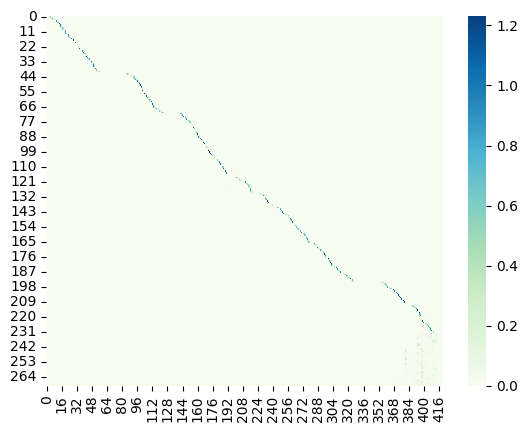

In [43]:
e                   = 0
best_loss           = 20

checkpoint_root = os.path.join(os.getcwd(), "checkpoints-basic-transformer")
os.makedirs(checkpoint_root, exist_ok=True)
wandb.watch(model, log="all")

checkpoint_best_loss_model_filename     = 'checkpoint-best-loss-model.pth'
checkpoint_last_epoch_filename          = 'checkpoint-epoch-'
best_loss_model_path                    = os.path.join(checkpoint_root, checkpoint_best_loss_model_filename)

if RESUME_LOGGING:
    # change if you want to load best test model accordingly
    checkpoint = torch.load(wandb.restore(checkpoint_best_loss_model_filename, run_path=""+run_id).name)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    e = checkpoint['epoch']

    print("Resuming from epoch {}".format(e+1))
    print("Epochs left: ", config['epochs']-e)
    print("Optimizer: \n", optimizer)

torch.cuda.empty_cache()
gc.collect()

epochs = config["epochs"]
for epoch in range(e, epochs):

    print("\nEpoch {}/{}".format(epoch+1, config["epochs"]))

    curr_lr = float(optimizer.param_groups[0]["lr"])

    train_loss, train_perplexity, attention_weights = train_model(model, train_loader, optimizer)

    print("\nEpoch {}/{}: \nTrain Loss {:.04f}\t Train Perplexity {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config["epochs"], train_loss, train_perplexity, curr_lr))

    if (epoch % 2 == 0):    # validate every 2 epochs to speed up training
        levenshtein_distance = validate_fast(model, val_loader)
        print("Levenshtein Distance {:.04f}".format(levenshtein_distance))
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr,
                "val_distance"      : levenshtein_distance})
    else:
        wandb.log({"train_loss"     : train_loss,
                "train_perplexity"  : train_perplexity,
                "learning_rate"     : curr_lr})

    # plotting the encoder-nearest and decoder-nearest attention weights
    attention_keys = list(attention_weights.keys())
    attention_weights_decoder      = attention_weights[attention_keys[-1]][0].cpu().detach().numpy()

    # saving the cross-attention weights
    save_attention_plot(attention_weights_decoder, epoch+100)

    # plot_attention_weights((attention_weights[attention_keys[0]][0]).cpu().detach().numpy())
    # plot_attention_weights(attention_weights[attention_keys[-1]][0].cpu().detach().numpy())

    if config["scheduler"] == "ReduceLR":
        scheduler.step(levenshtein_distance)
    else:
        scheduler.step()

    ### Highly Recommended: Save checkpoint in drive and/or wandb if accuracy is better than your current best
    epoch_model_path = os.path.join(checkpoint_root, (checkpoint_last_epoch_filename + str(epoch) + '.pth'))
    save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, epoch_model_path)
    ## wandb.save(epoch_model_path) ## Can't save on wandb for all epochs, may blow up storage

    print("Saved epoch model")

    if best_loss >= train_loss:
        best_loss = train_loss
        save_model(model, optimizer, scheduler, ['train_loss', train_loss], epoch, best_loss_model_path)
        # wandb.save(best_loss_model_path)
        print("Saved best training model")

### Finish your wandb run
# run.finish()

## Testing

In [44]:
torch.cuda.empty_cache()
gc.collect()
model.load_state_dict(torch.load('/content/checkpoints-basic-transformer/checkpoint-best-loss-model.pth')['model_state_dict'])

<All keys matched successfully>

In [45]:
model.eval()

# progress bar
batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, leave=False, position=0, desc="Test", ncols=5)

all_predictions = []

for i, data in enumerate(test_loader):
    inputs, inputs_lengths = data
    inputs                 = inputs.to(device)

    with torch.inference_mode():
        greedy_predictions = model.recognize(inputs, inputs_lengths)

    greedy_predictions = greedy_predictions.detach().cpu().numpy()

    for batch_idx in range(greedy_predictions.shape[0]):
        pred_sliced = indices_to_chars(greedy_predictions[batch_idx], vocab= VOCAB)
        pred_string = ''.join(pred_sliced)
        all_predictions.append(pred_string)

    batch_bar.update()

Test: 100%|██████████| 21/21 [08:07<00:00, 17.88s/it]

In [46]:
%cd /content/
df = pd.DataFrame({
    "index" : list(range(len(all_predictions))),
    "label" : all_predictions
})

df.to_csv("test.csv", index=False)

/content
